In [1]:
from qdisk.plot import ChannelMap, Map
from eDisk_source_dict import source_dict
import matplotlib.pyplot as plt
from matplotlib import ticker
from astropy.visualization import AsinhStretch, SinhStretch
import matplotlib.patheffects as pe
from matplotlib import patches
from qdisk.classes import FitsImage
import numpy as np
import analysis_utils as au
%matplotlib widget
%load_ext autoreload
%autoreload 2

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Dejavu Sans"],
#     "xtick.top": True,
#     "ytick.right": True,
#     "xtick.direction": "out",
#     "ytick.direction": "out"})

RAlabel = "$\Delta$R.A. [$^{\prime\prime}$]"
Declabel = "$\Delta$Dec. [$^{\prime\prime}$]"

source = "L1489IRS"
config = "SBLB"
lines = ["12CO", "13CO", "C18O", "SO"]
robust = {"12CO": 0.5, "13CO": 1.0, "C18O": 1.0, "SO": 1.0}
dv = 0.2
center_coord = source_dict[source]["radec"]
PA = source_dict[source]["PA"]
incl = source_dict[source]["incl"]
distance = source_dict[source]["distance"]
vsys = source_dict[source]["vsys"]
vrange = 6
nu0 = source_dict[source]["cont_nu0"]

def arcsec2au(r):
    return r * distance

def au2arcsec(r):
    return r / distance

### add beam prfoiel
def add_beam_profile(ax, beam, width_aspect=0.2, loc="upper right", aspect=0.6):
    xmin, xmax = ax.get_xlim()
    width = beam / (xmax - xmin) / width_aspect
    height = width * aspect
    if loc == "upper right":
        loc = [0.95-width, 0.95-height, width, height]
    elif loc == "lower left":
        loc = [0.05, 0.05, width, height]
    insax = ax.inset_axes(loc)
    x = np.arange(-0.5, 0.5, 0.001)
    beam_sigma = au.FWHM_to_sigma(width_aspect)
    y = np.exp(- x**2/(2*beam_sigma**2))
    insax.plot(x, y, color="grey")
    insax.axis("off")

contimagename = "/works/yamato/eDisk/L1489IRS/try1/trial_image_backup/L1489IRS_SBLB_continuum_robust_1.0.image.tt0.fits"

# continuum rms
contimage = FitsImage(contimagename)
contimage.estimate_rms(rmin=6)
contrms = contimage.rms
print("continuum beam size: {}'' x {}''".format(contimage.bmaj, contimage.bmin))
print("continuum rms: {:.3f} mJy/beam".format(contrms*1e3))


continuum beam size: 0.10507912188768'' x 0.07762632519006''
continuum rms: 0.014 mJy/beam


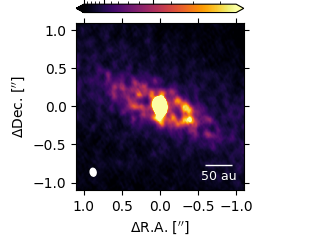

In [12]:
fig, ax = plt.subplots(constrained_layout=True)
rmax = 1.1
contmap = Map(contimagename, ax=ax, data_scaling_factor=1e3, xlim=(-rmax, rmax), ylim=(-rmax, rmax), center_coord=center_coord)
contmap.plot_colormap(cmap="inferno", vmin=0.0, vmax=0.27, stretch=SinhStretch())
contmap.add_colorbar(position="top", label="$I_\\nu$ [mJy beam$^{-1}$]", rotation=0, labelpad=5)
contmap.colorbar.ax.minorticks_on()
contmap.add_beam()
contmap.add_scalebar(scale=50. / distance, text="{:d} au".format(50))
contmap.set_labels(xlabel=RAlabel, ylabel=Declabel)
contmap.set_ticker(minor=False, majornticks=5, minornticks=5)
# r, t = contmap.get_disk_coord(PA=PA, incl=incl)
# contmap.overlay_contour(r, x=contmap.x, y=contmap.y, levels=np.array([0.40]), color="white", linestyle="dashed")
fig.savefig("./figure/continuum_map_zoom.png", bbox_inches="tight", pad_inches=0.01, dpi=800)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


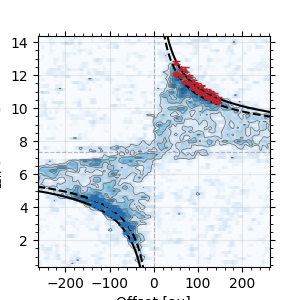

In [21]:
from mcmc_tools import EmceeHammer
from qdisk.plot import PVDiagram
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from matplotlib.legend_handler import HandlerTuple
from eDisk_source_dict import source_dict
# import eDiskplot
import analysis_utils as au

%matplotlib widget
%load_ext autoreload
%autoreload 2

source = "L1489IRS"
distance = source_dict[source]["distance"]
vsys = source_dict[source]["vsys"]
incl = source_dict[source]["incl"]

def arcsec2au(r):
    return r * distance

def au2arcsec(r):
    return r / distance

### add beam prfoiel
def add_beam_profile(ax, beam, width_aspect=0.2, loc="upper right", aspect=0.6):
    xmin, xmax = ax.get_xlim()
    width = beam / (xmax - xmin) / width_aspect
    height = width * aspect
    if loc == "upper right":
        loc = [0.95-width, 0.95-height, width, height]
    elif loc == "lower left":
        loc = [0.05, 0.05, width, height]
    insax = ax.inset_axes(loc)
    x = np.arange(-0.5, 0.5, 0.001)
    beam_sigma = au.FWHM_to_sigma(width_aspect)
    y = np.exp(- x**2/(2*beam_sigma**2))
    insax.plot(x, y, color="grey")
    insax.axis("off")

cmap = matplotlib.cm.get_cmap("RdBu")
red = cmap(0.12)
blue = cmap(0.88)

param_name = ["Mstar", "vsys"]
fitmode = ["edge", "ridge"]

### plot C18O PV diagram
imagename = "./VADP/L1489IRS_SBLB_C18O_robust_1.0_dv0.2.pbcor.PV_PA67.2deg.fits"
rms = 1.6  # in mJy/beam
rmax = 1.8*distance
vrange = 7
fig, ax = plt.subplots(figsize=(3, 3))
pvmap = PVDiagram(imagename, data_scaling_factor=1e3, ax=ax)
pvmap.posax *= distance
pvmap.plot_colormap(cmap="Blues", vmin=0.0)
pvmap.overlay_contour(
    levels=np.array([3, 5, 7, 9, 11, 13, 15]) * rms, color="dimgray", linewidth=0.5
)

### extrcated data points by SLAM
nom_vsys = []
handles = []
for mode in fitmode:
    datafilename = f"./SLAM/results/L1489IRS_SBLB_C18O_robust_1.0_dv0.2.image_pvDiagram_PA67.2.{mode}.dat"
    x, _, v, dv = np.loadtxt(datafilename, unpack=True)
    lr = pvmap.ax.errorbar(
        x[x > 0],
        v[x > 0] + vsys,
        yerr=dv[x > 0],
        fmt="^" if mode == "edge" else "o",
        markersize=3,
        color=red,
        capsize=3,
        lw=1
    )
    lb = pvmap.ax.errorbar(
        x[x < 0],
        v[x < 0] + vsys,
        yerr=dv[x < 0],
        fmt="^" if mode == "edge" else "o",
        markersize=3,
        color=blue,
        capsize=3,
        lw=1
    )
    handles.append((lr, lb))

    ### overplot Keplerian model
    ham = EmceeHammer()
    ham.load_backend(f"./fit/L1489IRS_C18O_Keplerian_fit_{mode}.h5")
    best_params = {pname: pval for pname, pval in zip(param_name, ham.get_MAP_params())}
    pvmap.add_Keplerian_curve(
        Mstar=best_params["Mstar"],
        distance=1.0,
        incl=incl,
        vsys=best_params["vsys"],
        rotation_sense=-1,
        color="black",
        ls="solid" if mode == "edge" else "dashed",
    )
    nom_vsys.append(best_params["vsys"])

nom_vsys = np.mean(nom_vsys)
### appearance
pvmap.ax.set(
    xlim=(-rmax, rmax),
    ylim=(nom_vsys - vrange, nom_vsys + vrange), xlabel="Offset [au]", ylabel="$v_\mathrm{LSR}$ [km s$^{-1}$]"
)
# pvmap.ax.tick_params(top=False, which="both")
pvmap.set_xaxis_ticker(minor=True, majornticks=6, minornticks=5)
pvmap.ax.minorticks_on()

### topax
# topax = pvmap.ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
# topax.xaxis.set_major_locator(ticker.MultipleLocator(100))
# topax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
# topax.set_xlabel("Offset [au]")

pvmap.ax.grid(alpha=0.25)
pvmap.ax.axhline(y=nom_vsys, color="grey", lw=0.8, alpha=0.5, ls="dashed")
pvmap.ax.axvline(x=0.0, color="grey", lw=0.8, alpha=0.5, ls="dashed")
# pvmap.ax.legend(handles, fitmode, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, loc="lower right")


add_beam_profile(ax=pvmap.ax, beam=pvmap.bmaj, width_aspect=0.3)

fig.savefig("./figure/C18O_PV_diagram_datapoints_curve.png", bbox_inches="tight", pad_inches=0.01, dpi=800)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


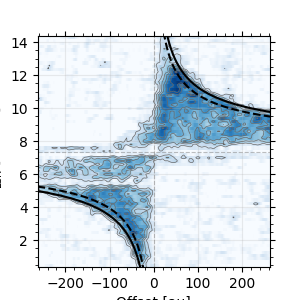

In [25]:
from mcmc_tools import EmceeHammer
from qdisk.plot import PVDiagram
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from matplotlib.legend_handler import HandlerTuple
from eDisk_source_dict import source_dict
# import eDiskplot
import analysis_utils as au

%matplotlib widget
%load_ext autoreload
%autoreload 2

source = "L1489IRS"
distance = source_dict[source]["distance"]
vsys = source_dict[source]["vsys"]
incl = source_dict[source]["incl"]

def arcsec2au(r):
    return r * distance

def au2arcsec(r):
    return r / distance

### add beam prfoiel
def add_beam_profile(ax, beam, width_aspect=0.2, loc="upper right", aspect=0.6):
    xmin, xmax = ax.get_xlim()
    width = beam / (xmax - xmin) / width_aspect
    height = width * aspect
    if loc == "upper right":
        loc = [0.95-width, 0.95-height, width, height]
    elif loc == "lower left":
        loc = [0.05, 0.05, width, height]
    insax = ax.inset_axes(loc)
    x = np.arange(-0.5, 0.5, 0.001)
    beam_sigma = au.FWHM_to_sigma(width_aspect)
    y = np.exp(- x**2/(2*beam_sigma**2))
    insax.plot(x, y, color="grey")
    insax.axis("off")

cmap = matplotlib.cm.get_cmap("RdBu")
red = cmap(0.12)
blue = cmap(0.88)

param_name = ["Mstar", "vsys"]
fitmode = ["edge", "ridge"]

### plot C18O PV diagram
imagename = "./VADP/L1489IRS_SBLB_13CO_robust_1.0_dv0.2.pbcor.PV_PA67.2deg.fits"
rms = 2.3  # in mJy/beam
rmax = 1.8 * distance
vrange = 7
fig, ax = plt.subplots(figsize=(3, 3))
pvmap = PVDiagram(imagename, data_scaling_factor=1e3, ax=ax)
pvmap.posax *= distance
pvmap.plot_colormap(cmap="Blues", vmin=0.0)
pvmap.overlay_contour(
    levels=np.array([3, 5, 7, 9, 11, 13, 15]) * rms, color="dimgray", linewidth=0.5
)

### extrcated data points by SLAM
nom_vsys = []
handles = []
for mode in fitmode:
    # datafilename = f"./SLAM/results/L1489IRS_SBLB_C18O_robust_1.0_dv0.2.image_pvDiagram_PA67.2.{mode}.dat"
    # x, _, v, dv = np.loadtxt(datafilename, unpack=True)
    # lr = pvmap.ax.errorbar(
    #     x[x > 0] / distance,
    #     v[x > 0] + vsys,
    #     yerr=dv[x > 0],
    #     fmt="^" if mode == "edge" else "o",
    #     markersize=3,
    #     color=red,
    #     capsize=3,
    #     lw=1
    # )
    # lb = pvmap.ax.errorbar(
    #     x[x < 0] / distance,
    #     v[x < 0] + vsys,
    #     yerr=dv[x < 0],
    #     fmt="^" if mode == "edge" else "o",
    #     markersize=3,
    #     color=blue,
    #     capsize=3,
    #     lw=1
    # )
    # handles.append((lr, lb))

    ### overplot Keplerian model
    ham = EmceeHammer()
    ham.load_backend(f"./fit/L1489IRS_C18O_Keplerian_fit_{mode}.h5")
    best_params = {pname: pval for pname, pval in zip(param_name, ham.get_MAP_params())}
    pvmap.add_Keplerian_curve(
        Mstar=best_params["Mstar"],
        distance=1.0,
        incl=incl,
        vsys=best_params["vsys"],
        rotation_sense=-1,
        color="black",
        ls="solid" if mode == "edge" else "dashed",
    )
    nom_vsys.append(best_params["vsys"])

nom_vsys = np.mean(nom_vsys)
### appearance
pvmap.ax.set(
    xlim=(-rmax, rmax),
    ylim=(nom_vsys - vrange, nom_vsys + vrange), xlabel="Offset [au]", ylabel="$v_\mathrm{LSR}$ [km s$^{-1}$]"
)
# pvmap.ax.tick_params(top=False, which="both")
pvmap.set_xaxis_ticker(minor=True, majornticks=6, minornticks=5)
pvmap.ax.minorticks_on()

### topax
# topax = pvmap.ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
# topax.xaxis.set_major_locator(ticker.MultipleLocator(100))
# topax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
# topax.set_xlabel("Offset [au]")

pvmap.ax.grid(alpha=0.25)
pvmap.ax.axhline(y=nom_vsys, color="grey", lw=0.8, alpha=0.5, ls="dashed")
pvmap.ax.axvline(x=0.0, color="grey", lw=0.8, alpha=0.5, ls="dashed")
# pvmap.ax.legend(handles, fitmode, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, loc="lower right")


add_beam_profile(ax=pvmap.ax, beam=pvmap.bmaj, width_aspect=0.3)

fig.savefig("./figure/13CO_PV_diagram_curve.png", bbox_inches="tight", pad_inches=0.01, dpi=800)


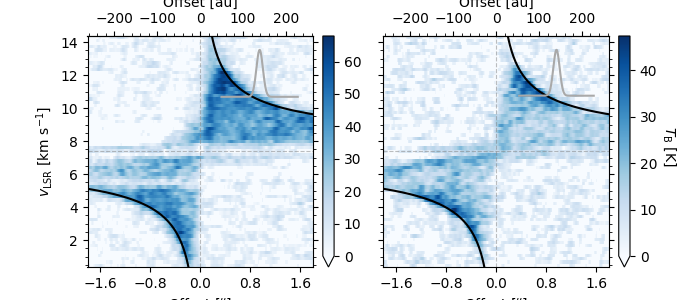

In [11]:
# import eDiskplot as eplot
import matplotlib.pyplot as plt
from eDisk_source_dict import source_dict
import matplotlib.patheffects as pe

source = "L1489IRS"
vsys = source_dict[source]["vsys"]
# Mstar = source_dict[source]["Mstar"]
Mstar = (1.498, 1.911)
Mstar = 1.7
distance = source_dict[source]["distance"]
incl = source_dict[source]["incl"]

def arcsec2au(r):
    return r * distance

def au2arcsec(r):
    return r / distance

### add beam prfoiel
def add_beam_profile(ax, beam, width_aspect=0.2, loc="upper right", aspect=0.6, **kwargs):
    xmin, xmax = ax.get_xlim()
    width = beam / (xmax - xmin) / width_aspect
    height = width * aspect
    if loc == "upper right":
        loc = [0.95-width, 0.95-height, width, height]
    elif loc == "lower left":
        loc = [0.05, 0.05, width, height]
    insax = ax.inset_axes(loc)
    x = np.arange(-0.5, 0.5, 0.001)
    beam_sigma = au.FWHM_to_sigma(width_aspect)
    y = np.exp(- x**2/(2*beam_sigma**2))
    color = kwargs.pop("color", "grey")
    insax.plot(x, y, color=color, **kwargs)
    insax.axis("off")

### PV diagrams of C18O and 13CO
imagename = {"13CO": "./VADP/L1489IRS_SBLB_13CO_robust_1.0_dv0.2.pbcor.PV_PA67.2deg.fits", "C18O": "./VADP/L1489IRS_SBLB_C18O_robust_1.0_dv0.2.pbcor.PV_PA67.2deg.fits"}
rmax = 1.8
label = ["(a)", "(b)"]

fig, axes = plt.subplots(1,2, figsize=(7,3), sharex=True, sharey=True)#, constrained_layout=True)

for i, (ax, line) in enumerate(zip(axes, imagename.keys())):
    pvmap = PVDiagram(imagename[line], ax=ax)
    pvmap.convert_unit()
    pvmap.plot_colormap(cmap="Blues", vmin=0.0)
    pvmap.add_Keplerian_curve(Mstar=Mstar, distance=distance, incl=incl, vsys=vsys, rotation_sense=-1, color="black")
    pvmap.ax.set(xlim=(-rmax, rmax), ylim=(vsys-7, vsys+7), facecolor="white", xlabel="Offset [$^{\prime\prime}$]", ylabel="$v_\mathrm{LSR}$ [km s$^{-1}$]" if i == 0 else None)
    pvmap.ax.tick_params(top=False, which="both")
    pvmap.ax.minorticks_on()
    pvmap.set_xaxis_ticker(minor=True, majornticks=5, minornticks=5)
    # pvmap.set_yaxis_ticker(minor=True, majornticks=5, minornticks=5)
    
    pvmap.ax.axhline(y=nom_vsys, color="grey", lw=0.8, alpha=0.5, ls="dashed")
    pvmap.ax.axvline(x=0.0, color="grey", lw=0.8, alpha=0.5, ls="dashed")
    pvmap.add_colorbar(label="$T_\mathrm{B}$ [K]" if i == 1 else None, labelpad=15)
    # pvmap.ax.grid(alpha=0.25)
    # pvmap.ax.annotate(
    #         text=label[i] + " " + eplot.linelabel[line],
    #         xy=(0.02, 0.98),
    #         xycoords="axes fraction",
    #         color="black",
    #         ha="left",
    #         va="top",
    #         path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
    #     )

    add_beam_profile(ax=pvmap.ax, beam=pvmap.bmaj, width_aspect=0.1, color="darkgrey")

    ### topax
    topax = pvmap.ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
    topax.xaxis.set_major_locator(ticker.MultipleLocator(100))
    topax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
    topax.set_xlabel("Offset [au]")

    # fig.savefig("./figure/13CO_C18O_PV_diagram.pdf", bbox_inches="tight", pad_inches=0.01)


In [ ]:
from tkinter import Scale
from matplotlib.ticker import ScalarFormatter, LogFormatter, StrMethodFormatter, FormatStrFormatter

filename = "./visibility/L1489IRS_continuum_shift.split.bin_30s.uvprofile.npz"
obsdata = np.load(filename)
uvdist = obsdata["uvdist"]
V = obsdata["V"]
Verr = obsdata["Verr"]

filename = "./L1489IRS_continuum_shift.split.bin_30s.MAP_vis.uvprofile.npz"
modeldata = np.load(filename)
modeluvdist = modeldata["uvdist"]
modelV = modeldata["V"]
modelVerr = modeldata["Verr"]

# oldvis = Visibility("./visibility/L1489IRS_continuum_shift_oldDDT.npz")
# oldvis.deproject(PA=param_dict["PA"], incl=param_dict["incl"])
# oldvis.shift_phase(dRA=-param_dict["dRA"], dDec=-param_dict["dDec"])
# olduvdist, oldV, oldVerr = oldvis.bin_1D()
# filename = "./L1489IRS_continuum_shift_oldDDT.uvprofile.npz"
# np.savez(filename, uvdist=olduvdist, V=oldV, Verr=oldVerr)


fig, axes = plt.subplots(
    2,
    1,
    figsize=(4, 3),
    sharex=True,
    gridspec_kw={"height_ratios": (3, 1)},
    constrained_layout=True,
)

ax = axes[0]
ax.errorbar(uvdist*1e-3, V.real*1e3, yerr=Verr.real*1e3, fmt="o", markersize=5)
ax.plot(modeluvdist*1e-3, modelV.real*1e3, zorder=100)
# ax.errorbar(olduvdist, oldV.real, yerr=oldVerr.real, fmt="o", markersize=5, zorder=2000)
ax.set(xscale="log", ylim=(0.8, 80), yscale="log", ylabel="Real [mJy]")
formatter = FormatStrFormatter("%.0f")
ax.yaxis.set_major_formatter(formatter)

ax = axes[1]
ax.errorbar(uvdist*1e-3, V.imag*1e3, yerr=Verr.imag*1e3, fmt="o", markersize=5)
ax.plot(modeluvdist*1e-3, modelV.imag*1e3, zorder=100)
# ax.errorbar(olduvdist, oldV.imag, yerr=oldVerr.imag, fmt="o", markersize=5, zorder=2000)
ax.set(ylim=(-2.2, 2.2), ylabel="Imag [mJy]", xlabel="Baseline [k$\lambda$]")

fig.savefig("./figure/visibility_plot.png", bbox_inches="tight", pad_inches=0.01, dpi=800)

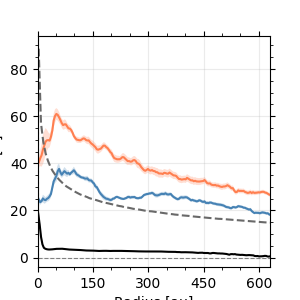

In [18]:
from eDisk_source_dict import source_dict
import matplotlib.patheffects as pe

source = "L1489IRS"
distance = source_dict[source]["distance"]

def add_beam_profile(ax, beam, width_aspect=0.2, loc="upper right", aspect=0.6, **kwargs):
    xmin, xmax = ax.get_xlim()
    width = beam / (xmax - xmin) / width_aspect
    height = width * aspect
    if loc == "upper right":
        loc = [0.95-width, 0.95-height, width, height]
    elif loc == "lower left":
        loc = [0.05, 0.05, width, height]
    else:
        loc = [*loc, width, height]
    insax = ax.inset_axes(loc)
    x = np.arange(-0.5, 0.5, 0.001)
    beam_sigma = au.FWHM_to_sigma(width_aspect)
    y = np.exp(- x**2/(2*beam_sigma**2))
    color = kwargs.pop("color", "grey")
    insax.plot(x, y, color=color, **kwargs)
    insax.axis("off")

### radial profiles of temperature and line ratio
profiledict = {
    "continuum": "./data/continuum_robust1.0_radial_profile_Tb.npz",
    "13CO": "./data/13CO_peak_radial_profile_Tb.npz",
    "C18O": "./data/C18O_peak_radial_profile_Tb.npz",
}

color = {"continuum": "black", "13CO": "coral", "C18O": "steelblue"}

fig, ax = plt.subplots(1,1, figsize=(3,3))#, constrained_layout=True)


for line in profiledict.keys():
    # load the data
    data = np.load(profiledict[line])
    r = data["r"]*distance
    Tb = data["Tb"]
    dTb = data["dTb"]
    
    # plot
    ax.plot(r, Tb, color=color[line])
    ax.fill_between(r, Tb-dTb, Tb+dTb, alpha=0.25, color=color[line], edgecolor=None)

modelprofilename = "./data/Sai20_model_Tdust_profile.npz"
data = np.load(modelprofilename)
ax.plot(data["r"], data["T"], color="dimgrey", ls="dashed")

ax.set(yscale="linear", xlim=(0, 630), ylim=(-4, 94), ylabel="$T$ [K]", xlabel="Radius [au]")
ax.axhline(y=0.0, color="grey", ls="dashed", lw=0.8)
ax.axvline(x=0.45, color="grey", ls="dotted")
# ax.annotate(
#             text="(a)",
#             xy=(0.02, 0.98),
#             xycoords="axes fraction",
#             color="black",
#             ha="left",
#             va="top",
#             path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
#         )
_, ymax = ax.get_ylim()
# ax.annotate(text="cont. ring",
#             xy=(0.45, ymax*0.9),
#             xycoords="data",
#             color="grey",
#             ha="left",
#             va="top",
#             rotation=270,)
            # path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],)
# ax.legend()
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax.grid(alpha=0.25)

fig.savefig("./figure/temperature_profiles.png", bbox_inches="tight", pad_inches=0.01, dpi=800)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


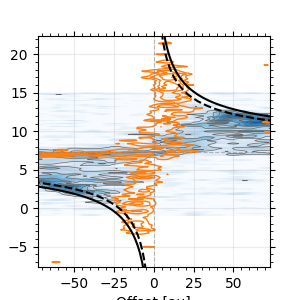

In [33]:
from mcmc_tools import EmceeHammer
from qdisk.plot import PVDiagram
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from matplotlib.legend_handler import HandlerTuple
from eDisk_source_dict import source_dict
# import eDiskplot
import analysis_utils as au

%matplotlib widget
%load_ext autoreload
%autoreload 2

source = "L1489IRS"
distance = source_dict[source]["distance"]
vsys = source_dict[source]["vsys"]
incl = source_dict[source]["incl"]

def arcsec2au(r):
    return r * distance

def au2arcsec(r):
    return r / distance

### add beam prfoiel
def add_beam_profile(ax, beam, width_aspect=0.2, loc="upper right", aspect=0.6):
    xmin, xmax = ax.get_xlim()
    width = beam / (xmax - xmin) / width_aspect
    height = width * aspect
    if loc == "upper right":
        loc = [0.95-width, 0.95-height, width, height]
    elif loc == "lower left":
        loc = [0.05, 0.05, width, height]
    insax = ax.inset_axes(loc)
    x = np.arange(-0.5, 0.5, 0.001)
    beam_sigma = au.FWHM_to_sigma(width_aspect)
    y = np.exp(- x**2/(2*beam_sigma**2))
    insax.plot(x, y, color="grey")
    insax.axis("off")

cmap = matplotlib.cm.get_cmap("RdBu")
red = cmap(0.12)
blue = cmap(0.88)

param_name = ["Mstar", "vsys"]
fitmode = ["edge", "ridge"]

### plot C18O PV diagram
imagename = "./VADP/L1489IRS_SBLB_C18O_robust_1.0_dv0.2.pbcor.PV_PA67.2deg.fits"
rms = 1.6  # in mJy/beam
rmax = 0.5 * distance
vrange = 15
fig, ax = plt.subplots(figsize=(3, 3))
pvmap = PVDiagram(imagename, data_scaling_factor=1e3, ax=ax)
pvmap.posax *= distance
pvmap.plot_colormap(cmap="Blues", vmin=0.0)
pvmap.overlay_contour(
    levels=np.array([3, 5, 7, 9, 11, 13, 15]) * rms, color="dimgray", linewidth=0.5
)

imagename = "./VADP/L1489IRS_SBLB_SO_robust_1.0_dv0.2.image_pvDiagram_PA85.fits"
rms = 2.0
pvmap = PVDiagram(imagename, data_scaling_factor=1e3, ax=ax)
pvmap.posax *= distance
pvmap.data = pvmap.data[:, ::-1]
# pvmap.plot_colormap(cmap="Oranges", vmin=0.0)
pvmap.overlay_contour(
    levels=np.array([3, 5, 7, 9, 11, 13, 15]) * rms, color="tab:orange", linewidth=1.0
)

### extrcated data points by SLAM
nom_vsys = []
handles = []
for mode in fitmode:
    # datafilename = f"./SLAM/results/L1489IRS_SBLB_C18O_robust_1.0_dv0.2.image_pvDiagram_PA67.2.{mode}.dat"
    # x, _, v, dv = np.loadtxt(datafilename, unpack=True)
    # lr = pvmap.ax.errorbar(
    #     x[x > 0] / distance,
    #     v[x > 0] + vsys,
    #     yerr=dv[x > 0],
    #     fmt="^" if mode == "edge" else "o",
    #     markersize=3,
    #     color=red,
    #     capsize=3,
    #     lw=1
    # )
    # lb = pvmap.ax.errorbar(
    #     x[x < 0] / distance,
    #     v[x < 0] + vsys,
    #     yerr=dv[x < 0],
    #     fmt="^" if mode == "edge" else "o",
    #     markersize=3,
    #     color=blue,
    #     capsize=3,
    #     lw=1
    # )
    # handles.append((lr, lb))

    ### overplot Keplerian model
    ham = EmceeHammer()
    ham.load_backend(f"./fit/L1489IRS_C18O_Keplerian_fit_{mode}.h5")
    best_params = {pname: pval for pname, pval in zip(param_name, ham.get_MAP_params())}
    pvmap.add_Keplerian_curve(
        Mstar=best_params["Mstar"],
        distance=1.0,
        incl=incl,
        vsys=best_params["vsys"],
        rotation_sense=-1,
        color="black",
        ls="solid" if mode == "edge" else "dashed",
    )
    nom_vsys.append(best_params["vsys"])

nom_vsys = np.mean(nom_vsys)
### appearance
pvmap.ax.set(
    xlim=(-rmax, rmax),
    ylim=(nom_vsys - vrange, nom_vsys + vrange), xlabel="Offset [au]", ylabel="$v_\mathrm{LSR}$ [km s$^{-1}$]"
)
# pvmap.ax.tick_params(top=False, which="both")
pvmap.set_xaxis_ticker(minor=True, majornticks=6, minornticks=5)
pvmap.ax.minorticks_on()

### topax
# topax = pvmap.ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
# topax.xaxis.set_major_locator(ticker.MultipleLocator(100))
# topax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
# topax.set_xlabel("Offset [au]")

pvmap.ax.grid(alpha=0.25)
pvmap.ax.axhline(y=nom_vsys, color="grey", lw=0.8, alpha=0.5, ls="dashed")
pvmap.ax.axvline(x=0.0, color="grey", lw=0.8, alpha=0.5, ls="dashed")
# pvmap.ax.legend(handles, fitmode, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, loc="lower right")


add_beam_profile(ax=pvmap.ax, beam=pvmap.bmaj, width_aspect=0.3)

fig.savefig("./figure/SO_C18O_PV_diagram_curve.png", bbox_inches="tight", pad_inches=0.01, dpi=800)


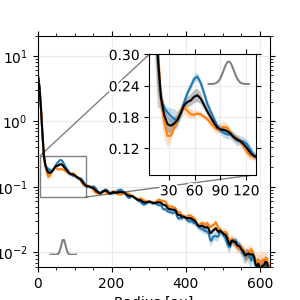

In [59]:
from pickletools import dis
from qdisk.classes import FitsImage
from eDisk_source_dict import source_dict
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(3,3))
config = "SBLB"
nu0 = source_dict[source]["cont_nu0"]
distance = source_dict[source]["distance"]

contimagename = "/works/yamato/eDisk/L1489IRS/try1/trial_image_backup/L1489IRS_SBLB_continuum_robust_1.0.image.tt0.fits"
# continuum rms
contimage = FitsImage(contimagename)

# ax = axes[3]
robust = 1.0
color = {"": "black", "West": "tab:blue", "East": "tab:orange"}

for side in ["West", "East", ""]:
    profilename = au.VADPpath + au.get_image_basename(
        source=source, line="continuum", baseline=config, robust=robust, type="image"
    ).replace(".fits", f"_radialProfileWedge45deg{side}.txt")

    r, I, dI = np.loadtxt(profilename, unpack=True)
    r *= distance
    I *= 1e3
    dI *= 1e3

    # color = "black" if side == "" else "grey"
    # ls = "solid" if side == "" else "dotted" if side == "West" else "dashed"
    ax.plot(r, I, color=color[side], ls="solid", label=side.lower() if side != "" else "both")
    ax.fill_between(r, I-dI, I+dI, alpha=0.25, facecolor=color[side], edgecolor=None)
    ax.set(xlim=(0, 4.3*distance))

# topax = ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
# topax.xaxis.set_major_locator(ticker.MultipleLocator(150))
# topax.minorticks_on()
# topax.tick_params(axis='x', which='major', pad=1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
# ax.yaxis.set_major_formatter(FormatStrFormatter("%.1g"))

ax.minorticks_on()
# ax.tick_params(top=False, which="both")


# if line == "continuum":
ax.set(yscale="log", ylim=(6e-3, 2e1), ylabel="$I_\\nu$ [mJy beam$^{-1}$]", xlabel="Radius [au]")
# topax.set_xlabel("Radius [au]", labelpad=7)
# topax.set
# topax.minorticks_on()
# ax.annotate(
#     text="(d)",
#     xy=(0.04, 0.93),
#     xycoords="axes fraction",
#     color="black",
#     ha="left",
#     va="center",
#     path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
# )
add_beam_profile(ax, beam=4*np.diff(r).mean(), loc="lower left")

# inset axis for zoom
insax = ax.inset_axes([0.48, 0.4, 0.46, 0.52])
xmin, xmax, ymin, ymax = 0.05*distance, 0.9*distance, 0.07, 0.3
insax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
# topinsax = insax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
# insax.tick_params(top=False)
# topinsax.xaxis.set_major_locator(ticker.MultipleLocator(30))
# topinsax.tick_params(axis='x', which='major', pad=0.1)
insax.xaxis.set_major_locator(ticker.MultipleLocator(30))
insax.yaxis.set_major_locator(ticker.MultipleLocator(0.06))
insax.grid(alpha=0.25)

# set patheffect
for ticks in insax.get_xticklabels():
    ticks.set_path_effects([pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
for ticks in insax.get_yticklabels():
    ticks.set_path_effects([pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
for side in ["West", "East", ""]:
    profilename = au.VADPpath + au.get_image_basename(
            source=source, line="continuum", baseline=config, robust=robust, type="image"
        ).replace(".fits", f"_radialProfileWedge45deg{side}.txt")

    r, I, dI = np.loadtxt(profilename, unpack=True)
    r *= distance
    I *= 1e3
    dI *= 1e3

    # color = "black" if side == "" else "grey"
    # ls = "solid" if side == "" else "dotted" if side == "West" else "dashed"
    insax.plot(r, I, color=color[side], ls="solid")
    insax.fill_between(r, I-dI, I+dI, alpha=0.25, facecolor=color[side], edgecolor=None)
ax.indicate_inset_zoom(insax, edgecolor="black")
ax.grid(alpha=0.25)
add_beam_profile(insax, beam=4*np.diff(r).mean(), aspect=0.5, width_aspect=0.3)


def jypb2K(I):
    return au.jypb_to_K(I*1e-3, nu0, contimage.beam[:2])

def K2jypb(I):
    return au.K_to_jypb(I, nu0, contimage.beam[:2])

# rightax = ax.secondary_yaxis("right", functions=(jypb2K, K2jypb))
# ax.tick_params(which="both", right=False)
# rightax.set_ylabel("$T_\mathrm{B}$ [K]", labelpad=7, rotation=270)
# rightax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
# # rightax.yaxis.set_minor_formatter(FormatStrFormatter("%.0f"))

fig.savefig("./figure/continuum_radial_profile.png", bbox_inches="tight", pad_inches=0.01, dpi=800)